# **Reduced Order Methods: an Introduction**
In this Lab we are going to introduce the main aspects of a parametric problem and the features that allow us to deal with it by means of Reduced Order Methods (ROMs).

First of all: ROMs are based on a Full Order Model (FOM). We can say also High Fidelity (HF) simulation.

Thus, we **need** a *standard* solver based on *standard discretizations*: in out case linear FE solvers.

Let us import the FOM library!

**MAIN IDEA**: look at the solution at FOM (full order model) level and after try to reduce it.

In [1]:
import sys
sys.path.append('../../CppToPython')

In [2]:
import numpy as np
import GeDiM4Py as gedim

In [3]:
# Just the configuration of the library
lib = gedim.ImportLibrary("/content/CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

## The parametric version of the heat conductivity equation

**Parametric problems**: problems with parameters that can change the phisics or geometry of the problem.

Solve the following equation on square ${\Omega} = (-1, +1) \times (-1, +1)$ (this is the domain)

$$
\begin{cases}
\nabla \cdot (k_{\mu} \nabla u) = 0 & \text{in } \Omega\\
k_{\mu} \nabla u \cdot n_1 = \mu_2 & \text{in } \Gamma_{base} \text{  Neuman condition}\\
u = 0 & \text{in } \Gamma_{top} \text{  Dirichlet condition}\\
k_{\mu} \nabla u \cdot n_2 = 0 & \text{otherwise} \text{  Omogeniuous condition}
\end{cases}
$$

where $k_{\mu} = \mu_1$ if $x^2 + y^2 \leq R^2$ and $k = 1$ otherwise, where $k_{\mu}$ is the parameter that is different related to the portion of domain we are.

**NB** Neuman condition has degree of freedom, on the contrary, Dirichlet do not have because in that portion of the domain, thanks to the condition, we how the value of the solution.

The parametric space is $\mathcal P = [0.1, 10] \times [-1,1]$, this is the parametric space that is defined as the portion of interval in which $\mu_1$ and $\mu_2$ change.

<img src="../Images/ROM_problem1_domain.png" width=30% style="margin-left:auto; margin-right:auto">

The parameter $\boldsymbol \mu \in \mathcal P$ is physical and changes the features of the flow: 

1. $\mu_1$ the conductivity in $\Omega_1$; --> how the flow diffusis
2. $\mu_2$ describes the heat flux in the bottom part of the boundary. --> how the flow exit from the bottom

First thing: we define two subdomains $\Omega_1$ and $\Omega_2$, such that
1. $\Omega_1$ is a disk in the origin with radius $r_0=0.5$ (defining the parameter), and
2. $\Omega_2=\Omega/\ \overline{\Omega_1}$.
3. $\Gamma_{base}$ to define where we will change the heat flux.

For a more exhaustive description of the problem refer to [this tutorial](https://colab.research.google.com/github/RBniCS/RBniCS/blob/open-in-colab/tutorials/01_thermal_block/tutorial_thermal_block.ipynb) based on [RBniCS library](https://www.rbnicsproject.org/).

In [15]:
# How to define portion of the domain in Gedim? Using functions

# define the radius 
def Heat_R():
	return 0.5 # Fixed the value of the radius

# define the disk: see the previuous picture
def Omega1(numPoints, points):
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    values = np.ones(numPoints) # Put 1 in the disk
    for p in range(0, numPoints):
        if(matPoints[0,p] * matPoints[0,p] + matPoints[1,p] * matPoints[1,p]) > (Heat_R() * Heat_R() + 1.0e-16):
            values[p] = 0.
    return values.ctypes.data

# define the complement of the disk: square \ disk (see in the picture wich region is)
def Omega2(numPoints, points):
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    values = np.ones(numPoints)
    for p in range(0, numPoints):
        # On the contrary, here we put zero in the disk
        # I put zero on the disk so where the value is less then the radius
        if(matPoints[0,p] * matPoints[0,p] + matPoints[1,p] * matPoints[1,p]) <= (Heat_R() * Heat_R() + 1.0e-16):
            values[p] = 0. 
    return values.ctypes.data

# define the bottom
def Gamma_base(numPoints, points): # The points of the bottom
	values = np.ones(numPoints) # The values of that point has to be equal to 1
	return values.ctypes.data

**Define the High Fidelity Simulation Parameters**:
for a parametric problem we need not only the order of the discretization, but also the parametric space definition.



In [16]:
order = 2 # Order of the discretization: order of the polynomi via we approximate the solution

# Fix the range for mu_1 and mu_2
mu1_range = [0.1, 10.]
mu2_range = [-1., 1.]

### Import Mesh

In [17]:
%%writefile ImportMesh.csv
InputFolderPath
../../CppToPython/Meshes/Mesh1

Writing ImportMesh.csv


In [18]:
[meshInfo, mesh] = gedim.ImportDomainMesh2D(lib)

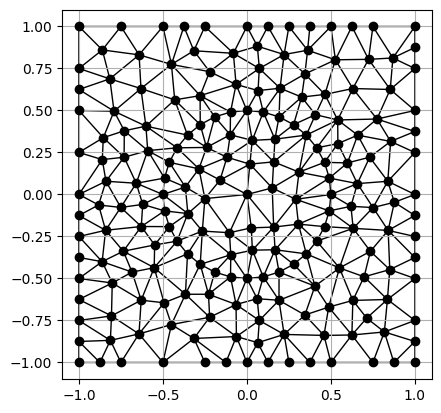

In [19]:
# Tringular mash in which we see the square domain ad also the inner disk
gedim.PlotMesh(mesh)

**Create Discrete Space FEM (the FOM approximation)**

In [20]:
#### Labels \Gamma_down = 1, \Gamma_side = 2 and \Gamma_top = 3
# As in the previous laboratory (see there if you do not remeber)
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 3, 3, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

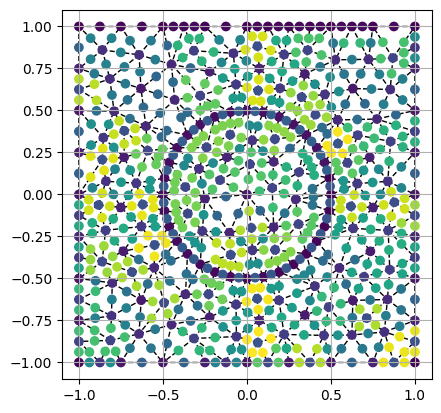

In [21]:
gedim.PlotDofs(mesh, dofs, strongs) 
# mesh, degree of freedom and strong = where Dirichlet condition are imposed

# The color of the point depends on the degree of freedom that you have on the point
# of the mesh

### **Assemble linear system exploting affinity**

To have a better understanding of the _affine decomposition_ let us define the _weak formulation_ of the problem:
given $\boldsymbol \mu \in \mathcal P$, find the solution $u(\boldsymbol \mu)$ that solves


$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space is
$$
\mathbb{V} = \{v\in H^1(\Omega) : v|_{\Gamma_{top}}=0\},
$$
* the bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is 
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \kappa_\mu \nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized forcing term $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is
$$f(v; \boldsymbol{\mu})= \mu_2\int_{\Gamma_{base}}v \ ds.$$

We want to compute the solution for **many** parameters in the parametric space.

**What does it means affinity of a problem?** Allows you to separate the variable: the prooblem can be written somehow in two part, one that depends on the parameters and onother one that does not depend on them. In this way, we can build an online and offline phase.
This helps to computer everithing in a faster way, because all the heavy calculation are in the offline phase. At the end of this phase, you can put the value of the parameter and start with the online phase. In this way, the online part is very efficient, and you have to performe the offline phase just once.

Notice that this problem is affine separable, so we can performe the affine decomposition.

Looking at the problem at hand, we notice that the system is _affine_!

Namely, it can be written as 
$$
\sum_{i=1}^{q_a} \theta_i^a(\boldsymbol \mu)a_i(u,v) = \sum_{i=0}^{q_f} \theta_i^f(\boldsymbol \mu)f_i(v),
$$
for $\theta_i^a(\boldsymbol \mu)$ and $\theta_i^f(\boldsymbol \mu)$ real functions and $q_a, q_f \in \mathbb N$.

Algebraic-wise (matrix representation), written in a compact form with matrix and vectors

$$
\sum_{i=1}^{q_a} \theta_i^a(\boldsymbol \mu)\mathsf A_i = \sum_{i=0}^{q_f} \theta_i^f(\boldsymbol \mu)\mathsf f_i,
$$
where $\mathsf A_i$ and $\mathsf f_i$ are the assembled matrices and vectors of the system.


The separation of variables, i.e. $\boldsymbol \mu$-dependent and $\boldsymbol \mu$-independent quantities, is really useful to divide the ROM process following the _offline_-_online_ paradigm (more details in the next Lab).

For now, let us focus on the FOM parametric version. Our problem is affine-decomposed in

$$a(u,v;\boldsymbol{\mu})=\underbrace{\mu_1}_{\Theta^{a}_1(\boldsymbol{\mu})}\underbrace{\int_{\Omega_1}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_1(u,v)} \ + \  \underbrace{1}_{\Theta^{a}_2(\boldsymbol{\mu})}\underbrace{\int_{\Omega_2}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_2(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{\mu_2}_{\Theta^{f}_1(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{base}}v \ ds}_{f_1(v)}.$$

This computation arrived from the "strong-wick" definition of the problem.

The **offline** phase is everithing you do before of computing the solution of the problem. Starts when you start the computation.

Let us define $\theta_i^a(\boldsymbol \mu)$ and $\theta_1^f(\boldsymbol \mu)$, for $i \in \{1,2\}$ with some numbers in the parametric range. 

In [22]:
thetaA1 = 1.
thetaA2 = 6.68
thetaf1 = 0.94

Let us define $a_1(u,v)$, $a_2(u,v)$ and $f(v)$,

In [23]:
# Definition of the matrices
# Related to Omega1
[stiffness1, stiffnessStrong1] = gedim.AssembleStiffnessMatrix(Omega2, problemData, lib)

# Related to Omega2
[stiffness2, stiffnessStrong2] = gedim.AssembleStiffnessMatrix(Omega1, problemData, lib)

# Assembling the forcing term
weakTerm_down1 = gedim.AssembleWeakTerm(Gamma_base, 1, problemData, lib)

and, finally, let us solve $a(u,v; \boldsymbol \mu) = f(v; \boldsymbol \mu)$.

In [24]:
a_mu = thetaA1*stiffness1 + thetaA2*stiffness2 # Just follow the formula
f_mu = thetaf1*weakTerm_down1

In [25]:
solution = gedim.LUSolver(a_mu, f_mu, lib) # Compute the solution

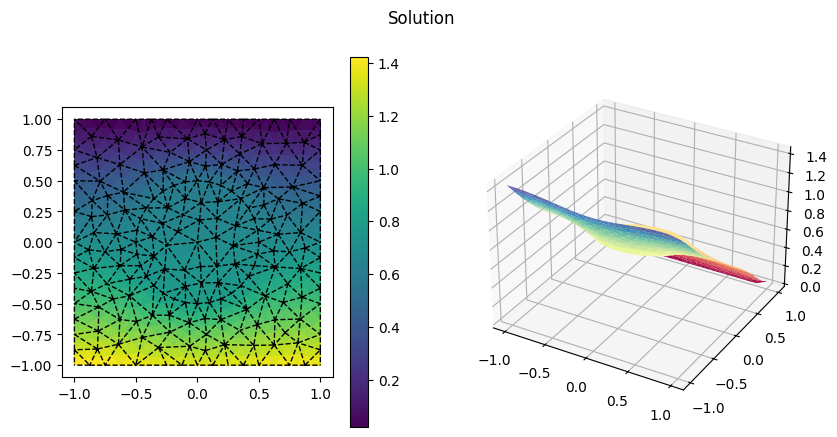

In [26]:
gedim.PlotSolution(mesh, dofs, strongs, solution, np.zeros(problemData['NumberStrongs']))

## **Let us do another exercise together** ##

Solve the following equation on square ${\Omega} = (-1, +1) \times (-1, +1)$

$$
\begin{cases}
\nabla \cdot (k_{\mu} \nabla u) + \beta_\mu x(1-x) \frac {\partial}{\partial x}u = f & \text{in } \Omega\\
u = 0 & \text{in } \Gamma_{top}\\
k_{\mu} \nabla u \cdot n_2 = 0 & \text{otherwise} 
\end{cases}
$$

where $k_\mu = \mu_i \in \Omega_i$ and $\beta_\mu = \mu_{4 + i} \in \Omega_i$ for $i \in \{1, \dots, 4\}$
The parametric space is $\mathcal P = [0.1, 5]^4 \times [1, 10]^4$. The forcing term is $f \equiv 10$.

Here, we have also the advection term.

<img src="../Images/ROMex.png" width=30% style="margin-left:auto; margin-right:auto">



Let us define the nodes of the boundary and the subdomains.

**How the domain looks like?** Here the domain is devided in 4 different subsquare. So it is a square divided in 4 subsquares with different parameters.


Let us define the nodes of the boundary and the subdomains.

In [27]:
# Definition of the forcig term
def Poisson_f(numPoints, points):
	values = 10*np.ones(numPoints) # It's 10 allover the domain
	return values.ctypes.data

# Definition of all the different squares of the domain
def Omega1_stiff(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.zeros(numPoints) # I put 0 everyway
	for p in range(0, numPoints):
		if ((matPoints[0,p]) <= 0) & ((matPoints[1,p])<= 0.): # (x and y) <= 0
			values[p] = 1. # Put 1 only in the square that I want to take in account
	return values.ctypes.data  

def Omega1_adv(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.zeros(numPoints)
	for p in range(0, numPoints):
		if ((matPoints[0,p]) <= 0.) & ((matPoints[1,p]) <= 0.): # The value is x*(1-x)
			values[p] = (matPoints[0,p] * (1.0 - matPoints[0,p]))
	return values.ctypes.data  

def Omega2_stiff(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.zeros(numPoints)
	for p in range(0, numPoints):
		if ((matPoints[0,p]) > 0.) & ((matPoints[1,p])<= 0.):
			values[p] = 1.
	return values.ctypes.data  

def Omega2_adv(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.zeros(numPoints)
	for p in range(0, numPoints):
		if ((matPoints[0,p]) > 0.) & ((matPoints[1,p])<= 0.):
			values[p] = (matPoints[0,p] * (1.0 - matPoints[0,p]))
	return values.ctypes.data  

def Omega3_stiff(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.zeros(numPoints)
	for p in range(0, numPoints):
		if ((matPoints[0,p]) <= 0) & ((matPoints[1,p])> 0.):
			values[p] = 1.
	return values.ctypes.data  

def Omega3_adv(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.zeros(numPoints)
	for p in range(0, numPoints):
		if ((matPoints[0,p]) <= 0) & ((matPoints[1,p])> 0.):
			values[p] = (matPoints[0,p] * (1.0 - matPoints[0,p]))
	return values.ctypes.data  

def Omega4_stiff(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.zeros(numPoints)
	for p in range(0, numPoints):
		if ((matPoints[0,p]) > 0.) & ((matPoints[1,p]) > 0.):
			values[p] = 1. 
	return values.ctypes.data  

def Omega4_adv(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.zeros(numPoints)
	for p in range(0, numPoints):
		if ((matPoints[0,p]) > 0.) & ((matPoints[1,p]) > 0.):
			values[p] = (matPoints[0,p] * (1.0 - matPoints[0,p]))
	return values.ctypes.data 

Also in this case we have an affine decomposition:

$$a(u,v;\boldsymbol{\mu})=
\sum_{i = 1}^4 \underbrace{\mu_i}_{\Theta^{a}_i(\boldsymbol{\mu}) \text{ for } i \in \{1, \dots, 4\}}\underbrace{\int_{\Omega_i}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_i(u,v) \text{ for } i \in \{1, \dots, 4\}} \ + \sum_{i = 5}^8 \underbrace{\mu_i}_{\Theta^{a}_i(\boldsymbol{\mu}) \text{ for } i \in \{5, \dots, 8\}}\underbrace{\int_{\Omega_i}x(1-x)\frac{\partial}{\partial x} u \cdot v \ d\boldsymbol{x}}_{a_i(u,v) \text{ for } i \in \{5, \dots, 8\}}$$
$$f(v; \boldsymbol{\mu}) = 10\underbrace{\int_{\Omega}v \ ds}_{f_1(v)}.$$

So we can say that the problem is affine decomponable.

Let us define the bilinear forms and the forcing term.

In [28]:
# Stiff matrices
[stiffness1, stiffnessStrong1] = gedim.AssembleStiffnessMatrix(Omega1_stiff, problemData, lib)
[stiffness2, stiffnessStrong2] = gedim.AssembleStiffnessMatrix(Omega2_stiff, problemData, lib)
[stiffness3, stiffnessStrong3] = gedim.AssembleStiffnessMatrix(Omega3_stiff, problemData, lib)
[stiffness4, stiffnessStrong4] = gedim.AssembleStiffnessMatrix(Omega4_stiff, problemData, lib)

# Advection matrices
[advection1, advectionStrong1] = gedim.AssembleAdvectionMatrix(Omega1_adv, problemData, lib)
[advection2, advectionStrong2] = gedim.AssembleAdvectionMatrix(Omega2_adv, problemData, lib)
[advection3, advectionStrong3] = gedim.AssembleAdvectionMatrix(Omega3_adv, problemData, lib)
[advection4, advectionStrong4] = gedim.AssembleAdvectionMatrix(Omega4_adv, problemData, lib)

# Forcing Term
forcingTerm = gedim.AssembleForcingTerm(Poisson_f, problemData, lib) # f=10

Let us define the ``thetas``.

In [29]:
# Definition of random thetas
thetaA1 = 1
thetaA2 = 2
thetaA3 = 3
thetaA4 = 4
thetaA5 = 10
thetaA6 = 10
thetaA7 = 1
thetaA8 = 10

In [30]:
# Global stiffness
stiffness = thetaA1*stiffness1  + thetaA2*stiffness2 + thetaA3*stiffness3 + thetaA4*stiffness4

# Global advection
advection = thetaA5*advection1 + thetaA6*advection2 + thetaA7*advection3 + thetaA8*advection4

# Left hand side of the equation is the summitiong of the two part that we already computed
lhs = stiffness + advection

In [31]:
stiffnessStrong = thetaA1*stiffnessStrong1 + thetaA2*stiffnessStrong2 + thetaA3*stiffnessStrong3 + thetaA4*stiffnessStrong4
advectionStrong = thetaA5*advectionStrong1 + thetaA6*advectionStrong2 + thetaA7*advectionStrong3 + thetaA8*advectionStrong4

# We set the forcing term
rhs = forcingTerm

Finally, let us solve the system.

In [32]:
solution = gedim.LUSolver(lhs, rhs, lib) # Computing the solution

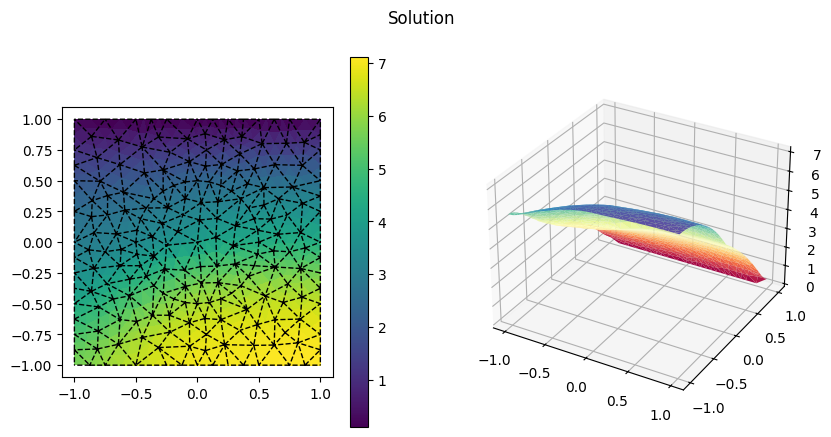

In [33]:
gedim.PlotSolution(mesh, dofs, strongs, solution, np.zeros(problemData['NumberStrongs']))

Solve the same problem with $u=2$ on $\Gamma_{top}$.

In [34]:
######################## Define the boundary condition as a vector of 2 #####################

# This is the difference as before (like a "forcing term") ("termine noto")
def Dirichlet_BoundaryTerm(numPoints, points):
	values = 2*np.ones(numPoints) # Before we had 10
	return values.ctypes.data

############################################################################################

def Poisson_f(numPoints, points):
	values = 10*np.ones(numPoints)
	return values.ctypes.data

def Omega1_stiff(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.zeros(numPoints)
	for p in range(0, numPoints):
		if ((matPoints[0,p]) <= 0) & ((matPoints[1,p])<= 0.):
			values[p] = 1. 
	return values.ctypes.data  

def Omega1_adv(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.zeros(numPoints)
	for p in range(0, numPoints):
		if ((matPoints[0,p]) <= 0.) & ((matPoints[1,p]) <= 0.):
			values[p] = (matPoints[0,p] * (1.0 - matPoints[0,p]))
	return values.ctypes.data  

def Omega2_stiff(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.zeros(numPoints)
	for p in range(0, numPoints):
		if ((matPoints[0,p]) > 0.) & ((matPoints[1,p])<= 0.):
			values[p] = 1.
	return values.ctypes.data  

def Omega2_adv(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.zeros(numPoints)
	for p in range(0, numPoints):
		if ((matPoints[0,p]) > 0.) & ((matPoints[1,p])<= 0.):
			values[p] = (matPoints[0,p] * (1.0 - matPoints[0,p]))
	return values.ctypes.data  


def Omega3_stiff(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.zeros(numPoints)
	for p in range(0, numPoints):
		if ((matPoints[0,p]) <= 0) & ((matPoints[1,p])> 0.):
			values[p] = 1. ### qui cambia
	return values.ctypes.data  

def Omega3_adv(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.zeros(numPoints)
	for p in range(0, numPoints):
		if ((matPoints[0,p]) <= 0) & ((matPoints[1,p])> 0.):
			values[p] = (matPoints[0,p] * (1.0 - matPoints[0,p]))
	return values.ctypes.data  

def Omega4_stiff(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.zeros(numPoints)
	for p in range(0, numPoints):
		if ((matPoints[0,p]) > 0.) & ((matPoints[1,p]) > 0.):
			values[p] = 1. ### qui cambia
	return values.ctypes.data  

def Omega4_adv(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.zeros(numPoints)
	for p in range(0, numPoints):
		if ((matPoints[0,p]) > 0.) & ((matPoints[1,p]) > 0.):
			values[p] = (matPoints[0,p] * (1.0 - matPoints[0,p]))
	return values.ctypes.data 

Also in this case we have an affine decomposition:

$$a(u,v;\boldsymbol{\mu})=
\sum_{i = 1}^4 \underbrace{\mu_i}_{\Theta^{a}_i(\boldsymbol{\mu}) \text{ for } i \in \{1, \dots, 4\}}\underbrace{\int_{\Omega_i}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_i(u,v) \text{ for } i \in \{5, \dots, 8\}} \ + \sum_{i = 1}^4 \underbrace{\mu_i}_{\Theta^{a}_i(\boldsymbol{\mu}) \text{ for } i \in \{5, \dots, 8\}}\underbrace{\int_{\Omega_i}x(1-x)\frac{\partial}{\partial x} u \cdot v \ d\boldsymbol{x}}_{a_i(u,v) \text{ for } i \in \{1, \dots, 4\}}$$
$$f(v; \boldsymbol{\mu}) = {10} \underbrace{\int_{\Omega}v \ ds}_{f_1(v)}.$$

Let us define the bilinear forms and the forcing term.

In [35]:
[stiffness1, stiffnessStrong1] = gedim.AssembleStiffnessMatrix(Omega1_stiff, problemData, lib)
[stiffness2, stiffnessStrong2] = gedim.AssembleStiffnessMatrix(Omega2_stiff, problemData, lib)
[stiffness3, stiffnessStrong3] = gedim.AssembleStiffnessMatrix(Omega3_stiff, problemData, lib)
[stiffness4, stiffnessStrong4] = gedim.AssembleStiffnessMatrix(Omega4_stiff, problemData, lib)

[advection1, advectionStrong1] = gedim.AssembleAdvectionMatrix(Omega1_adv, problemData, lib)
[advection2, advectionStrong2] = gedim.AssembleAdvectionMatrix(Omega2_adv, problemData, lib)
[advection3, advectionStrong3] = gedim.AssembleAdvectionMatrix(Omega3_adv, problemData, lib)
[advection4, advectionStrong4] = gedim.AssembleAdvectionMatrix(Omega4_adv, problemData, lib)

forcingTerm = gedim.AssembleForcingTerm(Poisson_f, problemData, lib)

#### computing the boundary condition. ATTENTION: 3 is the label of the mesh, in out case is \Gamma_down = 1, \Gamma_side = 2 and \Gamma_top = 3
DirichletTerm = gedim.AssembleStrongSolution(Dirichlet_BoundaryTerm, 3, problemData, lib) # 3 is the label for the top boundary
####

Let us define the ``thetas``.

In [36]:
#thetas
thetaA1 = 1
thetaA2 = 2
thetaA3 = 3
thetaA4 = 4
thetaA5 = 10
thetaA6 = 10
thetaA7 = 1
thetaA8 = 10
# thetaf1 = already assembled    

In [37]:
stiffness = thetaA1*stiffness1  + thetaA2*stiffness2 + thetaA3*stiffness3 + thetaA4*stiffness4
advection = thetaA5*advection1 + thetaA6*advection2 + thetaA7*advection3 + thetaA8*advection4
 
lhs = stiffness + advection

In [38]:
stiffnessStrong = thetaA1*stiffnessStrong1 + thetaA2*stiffnessStrong2 + thetaA3*stiffnessStrong3 + thetaA4*stiffnessStrong4
advectionStrong = thetaA5*advectionStrong1 + thetaA6*advectionStrong2 + thetaA7*advectionStrong3 + thetaA8*advectionStrong4

######### Change the RHS with the dirichlet term 
rhs = forcingTerm - (stiffnessStrong + advectionStrong ) @ DirichletTerm 
################

Finally, let us solve the system.

In [39]:
solution = gedim.LUSolver(lhs, rhs, lib)
print(max(solution))

9.108628829219256


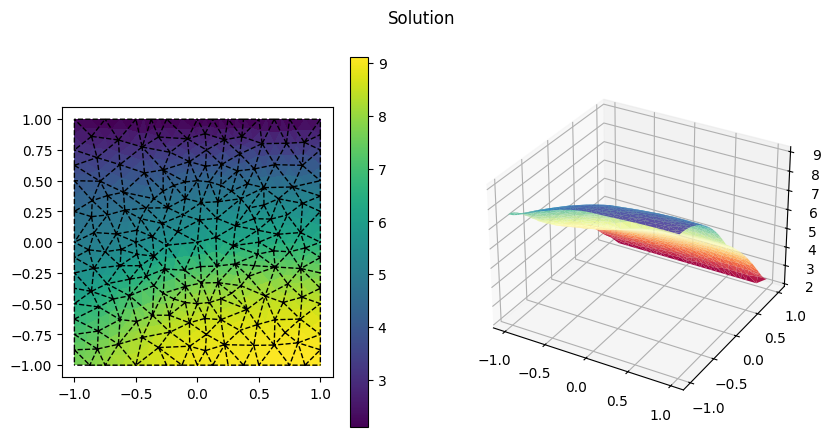

In [40]:
gedim.PlotSolution(mesh, dofs, strongs, solution, DirichletTerm) ### the last argument is the Dirichlet term